# Comparison with MD calculations at commensurate angles
Part 1: real space

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import interpolate
%matplotlib inline

In [2]:
# Load the displacements, indexed by atomic index
data = np.loadtxt('/Users/jonathanlu/Documents/tvGr/MD/rs67.txt')
npts = data.shape[0] // 6

x = []
y = []
z = []
for i, datum in enumerate(data):
    idx = (i % 3)
    if idx == 0:
        x.append(datum)
    elif idx == 1:
        y.append(datum)
    elif idx == 2:
        z.append(datum)
x = np.array(x)
y = np.array(y)
z = np.array(z)

x1 = []
x2 = []
y1 = []
y2 = []
z1 = []
z2 = []

for i, datum in enumerate(data):
    idx = (i % 6)
    
    if idx == 0:
        x1.append(datum)
    elif idx == 1:
        y1.append(datum)
    elif idx == 2:
        z1.append(datum)
    elif idx == 3:
        x2.append(datum)
    elif idx == 4:
        y2.append(datum)
    elif idx == 5:
        z2.append(datum)
        
x1 = np.array(x1)
y1 = np.array(y1)
z1 = np.array(z1)
x2 = np.array(x2)
y2 = np.array(x2)
z2 = np.array(x2)

In [3]:
# Load the equilibrium positions and atomic indices
a = np.loadtxt('/Users/jonathanlu/Documents/tvGr/MD/input_position.dat')[:,:-3]

# Reorder by atomic index
a = a[a[:, 0].argsort()]
coords = a[:,[0,4,5,6]]
layer_1 = (coords[:,-1] < 0)
layer_2 = (coords[:,-1] > 0)
cx = coords[:,1]
cy = coords[:,2]
cxy = coords[:,1:-1]
cz = coords[:,3]
print(x.shape)

coords1 = []
coords2 = []
for pt in a:
    if pt[-1] < 0:
        coords1.append(pt[-3:-1])
    elif pt[-1] > 0:
        coords2.append(pt[-3:-1])
        
coords1 = np.array(coords1)
coords2 = np.array(coords2)
print(coords1.shape, coords2.shape)

print(cxy)

(2884,)
(1442, 2) (1442, 2)
[[-31.67177774  57.28680228]
 [-30.24915377  57.2526238 ]
 [-32.35331125  56.10635162]
 ...
 [ 64.70680353   2.4297763 ]
 [ 63.28419512   2.39562121]
 [ 65.44771495   1.21483703]]


In [4]:
# Compute the moire lattice constant
lc = np.max(cx)
A = lc * np.array([[1,-1/2],[0,np.sqrt(3)/2]]).T

# Sample a mesh grid
line = np.linspace(0, 1-1/13, 13)
from itertools import product as prod
grid = np.array(list(prod(line, line)))
mesh = grid @ A

x1 = interpolate.griddata(cxy[layer_1], x[layer_1], mesh)
y1 = interpolate.griddata(cxy[layer_1], y[layer_1], mesh)
x2 = interpolate.griddata(cxy[layer_2], x[layer_2], mesh)
y2 = interpolate.griddata(cxy[layer_2], y[layer_2], mesh)

phi1 = np.pi / 200
R1 = np.array([[np.cos(phi1), np.sin(phi1)],[-np.sin(phi1), np.cos(phi1)]])
rcxy1 = cxy @ R1
cx1 = rcxy1[:,0]
cy1 = rcxy1[:,1]

phi2 = -np.pi / 200
R2 = np.array([[np.cos(phi2), np.sin(phi2)],[-np.sin(phi2), np.cos(phi2)]])
rcxy2 = cxy @ R2
cx2 = rcxy2[:,0]
cy2 = rcxy2[:,1]

In [23]:
import numpy.linalg as LA
f1 = np.logical_not(np.isnan(x1))
f2 = np.logical_not(np.isnan(x2))
mean_xy1 = np.mean(LA.norm(np.array([x1, y1])[:,f1], axis=0))
mean_xy2 = np.mean(LA.norm(np.array([x2, y2])[:,f2], axis=0))
mean_z1 = np.mean(np.abs(z[layer_1]))
mean_z2 = np.mean(np.abs(z[layer_2]))
print(f"Layer 1: mean xy = {mean_xy1}, mean z = {mean_z1}")
print(f"Layer 2: mean xy = {mean_xy2}, mean z = {mean_z2}")

Layer 1: mean xy = 0.013020272972805213, mean z = 0.00858253663667752
Layer 2: mean xy = 0.013020271298610489, mean z = 0.008582536832245634


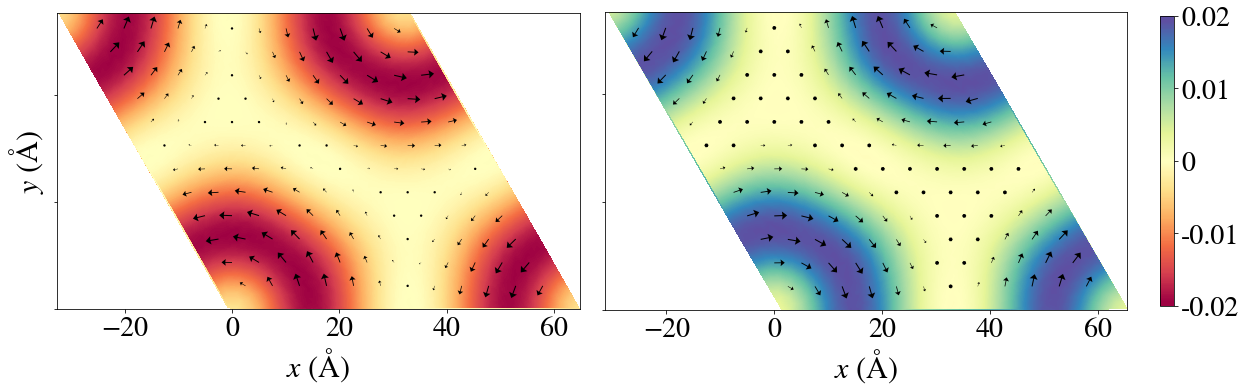

In [7]:
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(18,6), 
                              gridspec_kw={'width_ratios': [0.8, 1]},
                              sharey=True)
FONT_SIZE = 28

# make the default Font latex
plt.rc('font', size=20)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
minz, maxz = np.floor(np.min(z)*100)/100, np.ceil(np.max(z)*100)/100
n = len(coords1)
dd_factor = 1
dd = np.arange(n//dd_factor)*dd_factor


tcf = ax.tricontourf(cx1[layer_1], cy1[layer_1] - 1, z[layer_1], 
                     cmap='Spectral', levels=np.linspace(minz, maxz, 501), vmin=np.min(z), vmax=np.max(z))
cbar = plt.colorbar(tcf, shrink=0.8, ticks=[-0.02, -0.01, 0, 0.01, 0.02])
cbar.ax.set_yticklabels([-0.02, -0.01, 0, 0.01, 0.02], fontsize=FONT_SIZE)
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=FONT_SIZE)
ax.quiver(mesh[:,0], mesh[:,1],    # positions
            x1, y1, 
            width=0.005, minshaft=2.5, headwidth=8, scale=0.9, color='black') # arrows
ax.set_ylim(bottom=0, top=np.max(cy[layer_1])-2)

tcf2 = ax2.tricontourf(cx2[layer_2], cy2[layer_2], z[layer_2], 
                cmap='Spectral', levels=501, vmin=np.min(z), vmax=np.max(z))
ax2.quiver(mesh[:,0], mesh[:,1],    # positions
            x2, y2, 
            width=0.008, minshaft=2.5, headwidth=8, scale=0.9, color='black') # arrows

ax.tick_params(axis='both', labelsize=FONT_SIZE)
ax.set_aspect('equal')
ax.set_ylabel(r"$y$ ($\mathrm{\AA}$)", fontsize=FONT_SIZE+2)
ax.set_xlabel(r"$x$ ($\mathrm{\AA}$)", fontsize=FONT_SIZE+2)
ax2.tick_params(axis='both', labelsize=FONT_SIZE)
ax2.set_aspect('equal')
ax2.set_xlabel(r"$x$ ($\mathrm{\AA}$)", fontsize=FONT_SIZE+2)
ax2.set_yticklabels(ax.get_yticklabels())
plt.tight_layout()
plt.savefig("/Users/jonathanlu/Documents/data_mlph/MD_2_67.pdf")